In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
q = torch.tensor([
    # Planet/Binary
    0.4270, np.nan, 0.2342, np.nan, 0.234,
    # Binary/Plan
    0.303, np.nan, 0.0367, 0.0480, np.nan,
    np.nan, np.nan, 0.1448, 0.1284, np.nan,
    0.1734, 0.4270, np.nan,
    # Binary
    0.234, 0.356, 0.0722, 0.50, 0.234, 
    0.169, 0.0461, 0.4062, 0.316, 0.19, 
    0.594, np.nan, 0.187, 0.3675, 0.2342,
    0.945, 0.576, 0.532, np.nan, 0.457,
    0.0951, 0.904, 0.3675, 0.3554, 0.721,
    0.4962, 0.110, 0.7786, 0.4199, 0.4962,
    0.8809, 0.730, 0.7357, 0.152, 0.5766,
    0.1492, 0.4270, 0.9607, 0.0858, 0.7555,
    np.nan, 0.6700, 0.693, 0.231, 0.55844,
    0.4962, 0.081, 0.7405, 0.6700, 0.2015,
])

In [3]:
s = torch.tensor([
    # Planet/Binary
    0.3325, np.nan, 0.2084, np.nan, 0.434,
    # Binary/Plan
    0.55, np.nan, 0.946, 0.496, np.nan,
    np.nan, 1.010, 2.6540, 7.1626, np.nan,
    4.799, 6.2676, np.nan,
    # Binary
    3.674, 0.419, 0.49, 0.61, 6.700,
    1.086, 0.8625, 0.5430, 0.530, 1.10,
    2.049, np.nan, 0.670, 0.4342, 3.6747,
    1.304, 0.648, 1.9781, np.nan, 0.836,
    1.6496, 3.007, 1.7635, 0.8117, 2.858,
    3.2155, 2.015, 0.3554, 2.3031, 2.4621,
    1.5649, 0.596, 1.3634, 0.977, 3.0079,
    0.2084, 0.6480, 1.0780, 0.4847, 1.4483,
    np.nan, 0.332, 1.010, 0.898, 0.6555,
    1.1053, 0.406, 2.3733, 3.4374, 1.2887, 
])

In [4]:
targetdir = '/work/hmzhao/KMT_data/'
with h5py.File(targetdir + 'processed_data.h5', mode='r') as dataset_file:
    X_even = torch.tensor(dataset_file['X'][...]).float()
nanind = torch.where(~torch.isnan(q))[0]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
nanind = torch.where(~torch.isnan(s))[0]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)
print(len(train_coeffs))

57


In [5]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_21160.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = 6
input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [6]:
def get_negloglik(pi, normal, y):
    normal = torch.distributions.Normal(normal.loc[:, :, [2]], normal.scale[:, :, [2]])
    loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
    loglik = torch.sum(loglik, dim=2)
    loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
    return loss


num = len(X_even)
batchsize = len(X_even)
pred = torch.zeros((num, 6))
nll = torch.zeros((num,))
nll_sample = torch.zeros((num,))
model.eval()
for i in tqdm(range(num // batchsize)):
    torch.cuda.empty_cache()
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    # pred[i*batchsize:i*batchsize+batchsize] = model(batch).detach().cpu()
    pi, normal = model(batch)
    pred[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal).detach().cpu()
    nll[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, torch.log10(q).reshape(-1, 1)[i*batchsize:i*batchsize+batchsize].float().to(device)).detach().cpu()
    nll_sample[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, pred[i*batchsize:i*batchsize+batchsize, [2]].float().to(device)).detach().cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

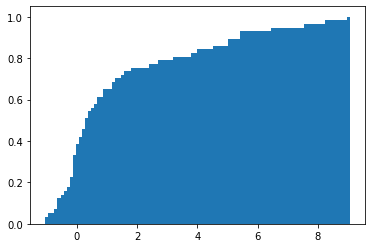

In [7]:
plt.hist(nll.numpy(), bins=100, density=True, cumulative=True)
plt.show()

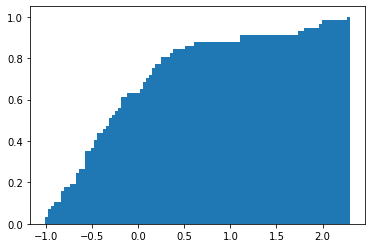

In [8]:
plt.hist(nll_sample.numpy(), bins=100, density=True, cumulative=True)
plt.show()

In [9]:
10**pred[:, 2]


tensor([8.1674e-02, 1.3530e-01, 4.9816e-01, 1.6505e-01, 7.4411e-01, 1.3955e-01,
        2.1775e-01, 3.7262e-01, 6.6343e-02, 4.8933e-01, 5.9218e-01, 2.6080e-01,
        7.0590e-01, 9.6237e-02, 2.3189e-01, 5.1526e-01, 3.8593e-01, 1.0797e+00,
        6.3242e-01, 2.5423e-01, 8.0024e-02, 7.6505e-01, 7.0197e-01, 1.4028e+00,
        2.9096e-01, 1.1567e+00, 3.1633e-01, 3.1785e-01, 3.0822e-02, 7.1843e-01,
        2.1457e-01, 4.4147e-01, 4.3284e-01, 2.3970e-01, 1.3480e-01, 4.6412e-01,
        6.3931e-01, 3.7971e-01, 2.8293e-01, 2.8647e-01, 4.8569e-01, 6.4766e-02,
        7.9482e-02, 8.2823e-01, 5.5741e-01, 3.3705e-03, 5.1256e-01, 1.0631e-03,
        1.7244e-01, 5.9224e-01, 9.6826e-01, 9.6514e-01, 3.3610e-01, 5.5478e-01,
        1.7946e-01, 2.6319e-01, 3.8979e-01])

In [10]:
q

tensor([0.4270, 0.2342, 0.2340, 0.3030, 0.0367, 0.0480, 0.1448, 0.1284, 0.1734,
        0.4270, 0.2340, 0.3560, 0.0722, 0.5000, 0.2340, 0.1690, 0.0461, 0.4062,
        0.3160, 0.1900, 0.5940, 0.1870, 0.3675, 0.2342, 0.9450, 0.5760, 0.5320,
        0.4570, 0.0951, 0.9040, 0.3675, 0.3554, 0.7210, 0.4962, 0.1100, 0.7786,
        0.4199, 0.4962, 0.8809, 0.7300, 0.7357, 0.1520, 0.5766, 0.1492, 0.4270,
        0.9607, 0.0858, 0.7555, 0.6700, 0.6930, 0.2310, 0.5584, 0.4962, 0.0810,
        0.7405, 0.6700, 0.2015])

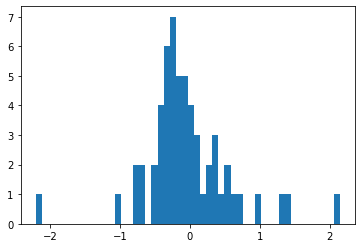

In [11]:
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.show()

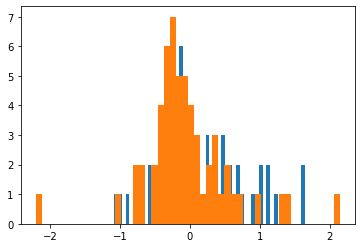

In [12]:
plt.hist(np.log10(np.abs(((torch.rand(len(q))*(-2) - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.show()

In [13]:
np.sum(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q))).numpy() < 1)/len(q)

0.6491228070175439

In [14]:
np.sum(np.abs(((torch.rand(len(q))*(-2) - torch.log10(q))/torch.log10(q))).numpy() < 1)/len(q)

0.543859649122807

In [15]:
torch.mean((pred[:, 2] - torch.log10(q))**2)

tensor(0.4868)

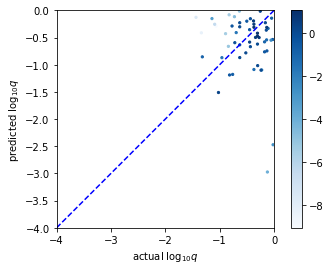

tensor([-0.3043, -1.0915, -0.1305, -0.1739, -0.6957])
[-0.4735275  -0.2558765  -0.74602705 -0.57973474 -0.40917474]
mse of log10q:  0.486846387386322


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(torch.log10(q), pred.numpy()[:, 2], s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(q)[-5:])
print(pred.numpy()[-5:, 2])
print('mse of log10q: ', torch.mean((torch.log10(q) -  pred.numpy()[:, 2])**2, dim=0).detach().cpu().item())

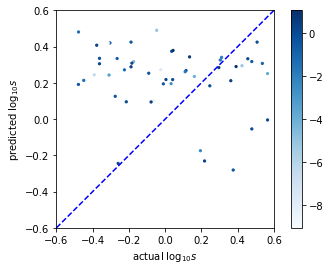

tensor([ 0.0435, -0.3915,  0.3754,  0.5362,  0.1102])
[ 0.37886655  0.24393743 -0.2811017   0.3073098   0.26127088]
mse of log10s:  0.2533407211303711


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(torch.log10(s), pred.numpy()[:, 3], s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(s)[-5:])
print(pred.numpy()[-5:, 3])
print('mse of log10s: ', torch.mean((torch.log10(s) -  pred.numpy()[:, 3])**2, dim=0).detach().cpu().item())

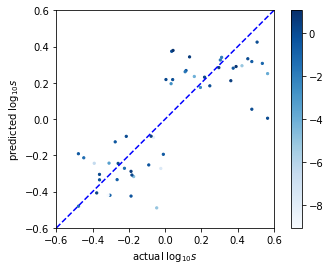

tensor([ 0.0435, -0.3915,  0.3754,  0.5362,  0.1102])
[ 0.37886655 -0.24393743  0.2811017   0.30730981  0.26127088]
mse of log10s:  0.05796574798290026


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(np.log10(s), pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1), s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(s)[-5:])
print((pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1))[-5:])
print('mse of log10s: ', torch.mean((torch.log10(s) -  pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1))**2, dim=0).detach().cpu().item())

tensor(0.3160) tensor(0.1423)


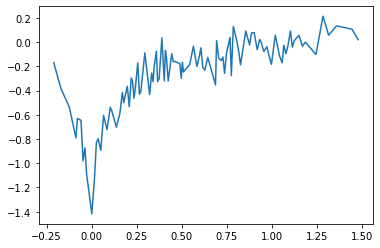

In [50]:
num = 18
print(q[num], 10**pred[num, 2])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.show()

In [21]:
# train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even[[num], :-120])

In [22]:
pi, normal = model(train_coeffs[[num]].float().to(device))

In [28]:
sample = model.sample(pi, normal).cpu().numpy()
print(sample)
print(torch.log10(q[num]))

[[ 0.13790676 -2.2170622  -0.71088976  0.3171575   1.1128039  -0.72799766]]
tensor(-0.5003)


In [29]:
# qsnormal = torch.distributions.Normal(normal.loc[:, :, [0, 3]], normal.scale[:, :, [0, 3]])
qsnormal = torch.distributions.Normal(normal.loc[:, :, [2, 3]], normal.scale[:, :, [2, 3]])
grid = torch.stack(torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
# grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
# y = torch.tile(Y[[num]], [10000, 1])
# y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, qsnormal, grid[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
torch.exp(-get_negloglik(pi, normal, torch.log10(q)[[num]].to(device))).detach().cpu(), \
torch.exp(-get_negloglik(pi, normal, model.sample(pi, normal)[:, 2].to(device)).detach().cpu()), \
torch.exp(-model.mdn_loss(pi, normal, model.sample(pi, normal).to(device)).detach().cpu())

(tensor([1.5691]), tensor([1.6609]), tensor(11.8825))

tensor(-0.5003)
[[ 0.13790676 -2.2170622  -0.71088976  0.3171575   1.1128039  -0.72799766]]


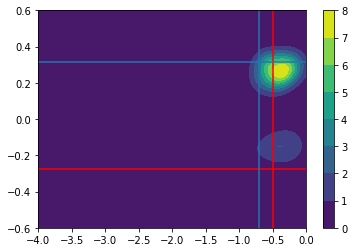

In [32]:
# sample = model.sample(pi, normal).detach().cpu().numpy()
x, y = torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100))
# x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100))
plt.contourf(x, y, prob.reshape(100, 100))
# plt.contourf(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100), prob.reshape(100, 100).T)
plt.hlines(np.log10(s[num]), -4, 0, colors='red')
plt.vlines(np.log10(q[num]), -0.6, 0.6, colors='red')
# plt.hlines(sample[0, 3], 0, 1)
# plt.vlines(sample[0, 0], -0.6, 0.6)
plt.hlines(sample[0, 3], -4, 0)
plt.vlines(sample[0, 2], -0.6, 0.6)
plt.colorbar()
print(torch.log10(q)[num])
print(sample)

In [33]:
sample[0, 0], 10**sample[0, 1], 10**sample[0, 2], 10**sample[0, 3], sample[0, 4]*np.pi, 10**sample[0, 5]

(0.13790676,
 0.006066493898323171,
 0.19458539635075903,
 2.0756661693272878,
 3.495976670237979,
 0.18706922169768014)

In [34]:
import MulensModel as mm
sample = model.sample(pi, normal).detach().cpu().numpy()
fs = 0.33
parameters = {
        't_0': 8551.968,
        't_E': 236.02,
        'u_0': 0.0390,
        'rho': 0.0028, 
        'q': 0.234, 
        's': 3.674, 
        'alpha': 3.105/np.pi*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-3*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-3*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
mag = - 2.5 * np.log10(fs*magnification + 1-fs) / 0.2
lc = np.stack([times, mag], axis=-1)

In [35]:
sample = model.sample(pi, normal).detach().cpu().numpy()
# fs = 1
parameters = {
        't_0': 8551.968,
        't_E': 236.02,
        'u_0': 0.039,
        'rho': 0.0028, 
        'q': 10**sample[0, 2], 
        's': 10**sample[0, 3], 
        'alpha': sample[0, 4]*np.pi,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-3*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-3*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
mag = -2.5 * np.log10(fs*magnification + 1-fs) / 0.2
lc_pred = np.stack([times, mag], axis=-1)

tensor(0.3160) 0.6891740445952964


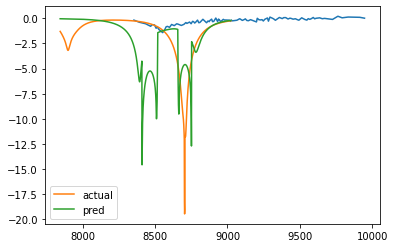

In [36]:
print(q[num], 10**sample[0, 2])
plt.plot(X_even[num, :, 0] * 236.02 * 4 + 8551.968, X_even[num, :, 1])
plt.plot(lc[:, 0], lc[:, 1], label='actual')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], label='pred')
plt.legend()
plt.show()

In [37]:
sample

array([[ 0.38775206, -2.4123724 , -0.16167109,  0.26694828,  0.382783  ,
        -0.6222799 ]], dtype=float32)

In [161]:
Y = torch.tensor([0.039, np.log10(0.0028), np.log10(0.234), np.log10(3.674), np.cos(3.105), np.sin(3.105)]).reshape(1, -1)
print(Y)

tensor([[ 0.0390, -2.5528, -0.6308,  0.5651, -0.9993,  0.0366]],
       dtype=torch.float64)
